In [ ]:
import sys
sys.path.insert(0, '..')

%load_ext prov_magics
import provn
import mutable_prov

# Comparison

In this document, we compare PROV, PROV-Dictionary and Versioned-PROV


## List Definition

For the list `[1, 2, 1]`, we have 2 entities to represent the literals `1` and `2` in all mappings:
```
entity(1, [value="1", type="name", generatedAtTime="T1"]) 
entity(2, [value="2", type="name", generatedAtTime="T2"])
```
Note that `generatedAtTime` is an optional prov attribute, but it is advisable to use it in Versioned-PROV. Thus, we represent all entities with this attribute. 


Besides these 2 entities, all mappings have an entity to represent the list definition itself, but the `type` attribute of the mappings change. In PROV and Versioned-PROV, the `type` must be a `prov:Collection`. In PROV-Dictionary, the `type` must be a `prov:Dictionary`. Note that all entity types that we use in the `script` namespace that we use in the examples (except `script:literal`, and `script:constant`) are subtype of `prov:Collection`, even when they do not represent collections. 
```
entity(list, [value="[1, 2, 1]", type="X", label="[1, 2, 1]", generatedAtTime="T3"])
```

The Plain PROV mapping use the `hadMember` statement to define members of the list. This statement does not indicate the position of the elements in the list. Since this information is important to reconstruct the path in the provenance query of Floyd-Warshall, we create extra nodes that encode the list position and we derive theses nodes from the original literal entities, by using the `definelist` activity:
```
activity(definelist1, [type="script:definelist"])
wasGeneratedBy(list, definelist1, -)

entity(list0, [value="1", type="script:item", label="1"])
hadMember(list, list0)
used(u1; definelist1, 1, -)
wasGeneratedBy(g1; list0, definelist1, -)
wasDerivedFrom(list0, 1, definelist1, g1, u1)

entity(list1, [value="1", type="script:item", label="2"])
hadMember(list, list1)
used(u2; definelist1, 2, -)
wasGeneratedBy(g2; list1, definelist1, -)
wasDerivedFrom(list1, 2, definelist1, g2, u2)

entity(list2, [value="2", type="script:item", label="1"])
hadMember(list, list2)
used(u3; definelist1, 1, -)
wasGeneratedBy(g3; list2, definelist1, -)
wasDerivedFrom(list2, 1, definelist1, g3, u3)
```
Thus, for defining a list with `N` elements in PROV, we have:
- `1` `activity`
- `1 + N` `entity`
- `N` `hadMember`
- `N` `used`
- `N` `wasDerivedFrom`
- `1 + N` `wasGeneratedBy`,
- `= 3 + 5N` constructs

In addition to all `entities` that appear in the list.


Different from Plain PROV, PROV-Dictionary can define list elements with their positions, and can use a single statement, `wasDerivedByInsertionFrom`, to associate member entities to a collection entity. However, since it does not indicate the position of accesses, we still need to create extra entities to encode the position. Additionally, we also need a global `EmptyDictionary` entity for the derivation:
```
entity(empty, [value="[]", type="EmptyDictionary"])

activity(definelist1, [type="script:definelist"])
wasGeneratedBy(list, definelist1, -)

entity(list0, [value="1", type="script:item", label="1"])
used(u1; definelist1, 1, -)
wasGeneratedBy(g1; list0, definelist1, -)
wasDerivedFrom(list0, 1, definelist1, g1, u1)

entity(list1, [value="1", type="script:item", label="2"])
used(u2; definelist1, 2, -)
wasGeneratedBy(g2; list1, definelist1, -)
wasDerivedFrom(list1, 2, definelist1, g2, u2)

entity(list2, [value="2", type="script:item", label="1"])
used(u3; definelist1, 1, -)
wasGeneratedBy(g3; list2, definelist1, -)
wasDerivedFrom(list2, 1, definelist1, g3, u3)

derivedByInsertionFrom(
    list, empty,
    {("0", list0), ("1", list1), ("2", list2)}
)
```
Thus, for defining a list with `N` elements in PROV-Dictionary, we have:
- `1` `activity`
- `1 + N` `entity`
- `1` `derivedByInsertionFrom`
- `N` `used`
- `N` `wasDerivedFrom`
- `1 + N` `wasGeneratedBy`,
- `= 4 + 4N` constructs + `1` global `EmptyDictionary` entity

In addition to all `entities` that appear in the list.


Versioned-PROV is capable of defining list elements with their positions using the `hadMember` statement with extra attributes, and it also indicates the accessed positions. Thus, Versioned-PROV queries can handle list accesses without requiring extra constructs:
```
hadMember(list, 1, [type="versioned:Insertion", versioned:key="0", versioned:moment="T3"])
hadMember(list, 2, [type="versioned:Insertion", versioned:key="1", versioned:moment="T3"])
hadMember(list, 1, [type="versioned:Insertion", versioned:key="2", versioned:moment="T3"])
```
Thus, for definining a list witn `N` elements in Versioned-PROV, we have
- `1` `entity` for the list
- `N` `hadMember`
- `= 1 + N` constructs

In addition to all `entities` that appear in the list.



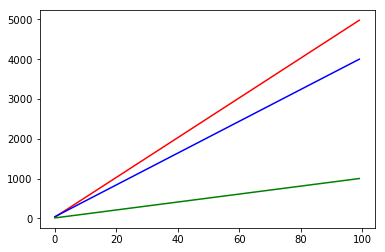

In [14]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# evenly sampled time at 200ms intervals
t = np.arange(0, 100, 1)

# red dashes, blue squares and green triangles
def prov(n, count, color):
    return (n, count * (3 + 5 * n), color)

def dic(n, count, color):
    return (n, 1 + count * (4 + 4 * n), color)

def ver(n, count, color):
    return (n, count * (1 + n), color)

plt.plot(*prov(t, 10, 'r'), *dic(t, 10, 'b'), *ver(t, 10, 'g')) 
plt.show()